## 运行环境

In [1]:
%load_ext watermark
%watermark

2017-12-31T17:19:44+01:00

CPython 3.6.2
IPython 6.0.0

compiler   : GCC 4.2.1 (Apple Inc. build 5666) (dot 3)
system     : Darwin
release    : 15.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [18]:
import pandas as pd
import jieba
import time
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import tensorflow as tf
print(tf.__version__)

1.1.0


## 构建一个词的 Word Embedding
在构建统计语言模型的时候，我们把所有看到的词都放入了 dict 里面，这时候影响不大，因为每个词占用的内存较小。

在使用神经网络做自然语言处理的时候，我们一般都会对词表做一个截断操作，取最高频的 n 个（也有人按词频阈值做截断）。这样有两个好处：
1. 减少模型的内存使用。
2. 只出现过一两次的词，在整个优化过程中往往也很难学好。不如把这些词直接全看成未登录词。

In [3]:
tf.reset_default_graph()

In [4]:
# 决定了 embedding 的维度 （隐层节点数）
word_embedding_dim = 128
# 决定了词表数量, 预留一个未登录词
vocab_size = 80000 + 1
UNK_IDX = 0

# 这里需要把 Word embedding 放到 Variable 里面。因为 Word embedding 是要随机初始化，跟着数据不断变化的。
# 它相当于普通神经网络中的权重。

# 在梯度下降时， tensorflow 的 Optimizer 会自动找到 Graph 中的 Variable，计算梯度并进行更新。
word_embedding = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))

# placeholder 和 variable 基本都可以当做 Tensor 来用
# 注意这里的输入是 int32 类型，表示一个词 ID。这里我们需要对数据进行预处理，以把高频词映射到 [1, 80000] 之间，不在词表里面的词设置成 UNK, ID 为 0
# 这里我们假设输入是两个词

# 这里 Shape 的第一维我们指定为 None，是表示第一维可以根据数据进行变化，因此同样一个程序可以适应梯度下降时不同的 batch_size
input_data = tf.placeholder(tf.int32, shape=[None, 2], name='input_data')

input_embeds = tf.nn.embedding_lookup(word_embedding, input_data)

因为 input_data 是一个二维矩阵，lookup 之后得到的其实是一个『三维的矩阵』

怎么理解呢？如果我们一个样本有两个词，拿到的就是矩阵的两行，因此是一个矩阵

但是我们同时有多个样本，因此需要对这个矩阵再『扩张』一个维度。而这个维度因为数据还未给出，大小是未知的

In [5]:
input_embeds

<tf.Tensor 'embedding_lookup:0' shape=(?, 2, 128) dtype=float32>

### 两个词的向量做相加

In [6]:
# reduce 开头的函数一般有一个 axis 参数，决定按行、按列或者按整个矩阵进行 reduce
context_embeds = tf.reduce_sum(input_embeds, axis=1)

In [7]:
# 注意观察 context_embds 的 shape
# 因为 placeholder 第一位的维度是 None，这里 TF 没法确切知道第一维最后的 shape
context_embeds

<tf.Tensor 'Sum:0' shape=(?, 128) dtype=float32>

### 相加的词向量再映射到 N 个词的概率分布

In [8]:
# 激活之前的输出
raw_output = tf.layers.dense(context_embeds, vocab_size)

In [15]:
output = tf.nn.softmax(raw_output)

In [9]:
# 加 softmax 之后的输出
final_output = tf.nn.softmax(raw_output)

In [11]:
with tf.Session() as sess:
    # 因为引入了 variable，所以需要进行初始化
    sess.run(tf.global_variables_initializer())
    # 输出的矩阵比较大，我们只看前 10 列
    print(sess.run(final_output, feed_dict={input_data: np.asarray([[1, 2]])})[:, :10])

[[  1.30378403e-05   1.39868280e-05   1.24939406e-05   1.25732822e-05
    1.20092827e-05   1.19113729e-05   1.33065150e-05   1.19917358e-05
    1.17512154e-05   1.26534314e-05]]


- 同第三讲示例代码中的类似 (sigmoid + cross entropy)，softmax 配合 cross entropy 的时候，在求导时两个连着看，也可以做分母的消除，因此在计算 cost 的时候我们要把 raw_output 喂给 tf 的这个损失函数

In [12]:
# 样本的 labels 也需要用 placeholder 放置
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

# 因为我们每个样本的 label 只有一个，使用稠密的 softmax 算 cost 及求导太浪费了。这里使用 sparse 版本即可。
# 如果你的 label 是完整的 N 个词上的概率分布，这时候可以使用 tf.nn.softmax_cross_entropy_with_logits
cost = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=raw_output, labels=labels)

In [17]:
train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    dummy_feed_dict = {input_data: np.asarray([[1, 2]]),
                       labels: np.asarray([3])}
    for i in range(100):
        sess.run(train_step, feed_dict=dummy_feed_dict)
        if i % 20 == 0:
            print("Iteration %d" % i)
            print("Cost: %f" % cost.eval(feed_dict=dummy_feed_dict)[0])
            # 查看输出中 ID == 3 的概率
            print("Probability: %f" % output.eval(session= sess,feed_dict=dummy_feed_dict)[0, 3])
            print("------")

Iteration 0
Cost: 9.917473
Probability: 0.000012
------
Iteration 20
Cost: 0.051485
Probability: 0.000012
------
Iteration 40
Cost: 0.020021
Probability: 0.000012
------
Iteration 60
Cost: 0.011911
Probability: 0.000012
------
Iteration 80
Cost: 0.009303
Probability: 0.000012
------


训练语料库，并完成 3 个名词各自最相近的 Top 10 个词的检索

In [89]:
def generate_LM(filepath, ngram=1):
    lm = defaultdict(Counter)
    with open(filepath,'r') as f:
        for line in f:
            line = re.sub(r"([%s]+)" % u'。？！', r"\1\n", line.strip())
            words = pseg.cut(line)
            words = [i.word for i in words]
            if len(words):
                #为了统计句首的几个词，采用padding手段，在句首添加ngram个'<S>'
                words = ['<S>'] * ngram + words
                for i in range(ngram, len(words)):
                    context = tuple(words[i-ngram : i])
                    word = words[i]
                    lm[context][word] += 1
    return lm

In [91]:
read_size = 100000
vocab_size = 2000 + 1  # 预留一个未登录词

with open('一个分成两半的子爵.txt', encoding='utf-8') as f:
    corpus = f.read(read_size) #建立语料库

words = [word for word in jieba.cut(corpus) if word not in ' \n']
word_cnt = Counter(words)
vocab = [i[0] for i in word_cnt.most_common(vocab_size - 1)]  # 词表(高频截断)

# 将语料序列映射到 [0, vocab_size - 1] 内的整数, 未登录词为 0
word_ids = [vocab.index(word) if (word in vocab) else 0 
            for word in words]

# 生成训练数据
inputs_train = np.asarray([[word_ids[i-1], word_ids[i+1]] 
                           for i in range(1, len(word_ids) - 1)])
labels_train = np.asarray(word_ids[1:-1])

# 查看截断位置的词频
word_cnt.most_common(vocab_size)[-5:]

[('骑着马', 2), ('解开', 2), ('决心', 2), ('造物', 2), ('恶', 2)]

In [92]:
len(corpus), len(words), len(vocab), inputs_train.shape, labels_train.shape

(46650, 30329, 2000, (30327, 2), (30327,))

In [93]:
tf.reset_default_graph()
word_embedding_dim = 50
word_embeddings = tf.Variable(tf.random_uniform([vocab_size, word_embedding_dim]))
inputs = tf.placeholder(tf.int32, shape=[None, 2], name='inputs')
labels = tf.placeholder(tf.int32, shape=[None], name='labels')

In [94]:
input_embeds = tf.nn.embedding_lookup(word_embeddings, inputs)
input_embeds

<tf.Tensor 'embedding_lookup:0' shape=(?, 2, 50) dtype=float32>

In [95]:
context_embeds = tf.reduce_sum(input_embeds, axis=1)
context_embeds

<tf.Tensor 'Sum:0' shape=(?, 50) dtype=float32>

In [96]:
raw_output = tf.layers.dense(context_embeds, vocab_size)
output = tf.nn.softmax(raw_output)
raw_output.shape, labels_train.shape

(TensorShape([Dimension(None), Dimension(2001)]), (30327,))

In [97]:
cost = tf.reduce_mean(
    tf.nn.sparse_softmax_cross_entropy_with_logits(logits=raw_output, labels=labels))


In [98]:
labels.shape, labels_train.shape, inputs.shape, inputs_train.shape

(TensorShape([Dimension(None)]),
 (30327,),
 TensorShape([Dimension(None), Dimension(2)]),
 (30327, 2))

In [99]:
learning_rate = 3
epochs = 1000
print_cost_every = 10
batch_size = 100
feed = {inputs: inputs_train, labels: labels_train}  # full-batch feed

In [100]:
#writer = tf.summary.FileWriter('/tensorflow/tf')
cost_summary = tf.summary.scalar('cost_', cost)
embedding_summary = tf.summary.histogram('embeddings_', word_embeddings)
merged = tf.summary.merge_all()

train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
costs = []

# 训练集的随机序号
num_inputs = len(labels_train)
order = np.arange(num_inputs)
np.random.shuffle(order)

start_time = time.time()

try:
    for i in range(epochs):
        if i % print_cost_every == 0:
            cost_value, merged_value = sess.run([cost, merged], feed_dict=feed)
            print("Epoch {:03d} - Cost: {:.5f}".format(i, cost_value))
            costs.append(cost_value)
          #  writer.add_summary(merged_value, i)
        for j in range(0, num_inputs, batch_size):
            batch_index = order[j: j + batch_size]
            batch_inputs = inputs_train[batch_index]
            batch_labels = labels_train[batch_index]
            batch_feed = {inputs: batch_inputs, labels: batch_labels}
            sess.run(train_step, feed_dict=batch_feed)
except KeyboardInterrupt:
    print('KeyboardInterrupt')
finally:
    end_time = time.time()
    print('\ntime: {:.2f} s'.format(end_time - start_time))

Epoch 000 - Cost: 7.61401
Epoch 010 - Cost: 3.29275
Epoch 020 - Cost: 2.90148
Epoch 030 - Cost: 2.84078
Epoch 040 - Cost: 2.84880
Epoch 050 - Cost: 2.86327
KeyboardInterrupt

time: 173.71 s


In [101]:
plt.plot(costs)

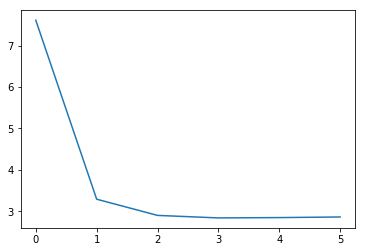

In [102]:
plt.show()

In [103]:
validate_words = ['解开', '决心', '造物']
validate_ids = [vocab.index(word) for word in validate_words]
validate_inputs = tf.constant(validate_ids, dtype=tf.int32)

norm = tf.sqrt(tf.reduce_sum(tf.square(word_embeddings), 1, keep_dims=True))
normalized_embeddings = word_embeddings / norm
validate_embeddings = tf.nn.embedding_lookup(normalized_embeddings, validate_inputs)
similarity = tf.matmul(validate_embeddings, normalized_embeddings, transpose_b=True)

In [104]:
sim_values = sess.run(similarity, feed_dict=feed)
for i in range(len(validate_words)):
    word = validate_words[i]
    similar_ids = (-sim_values[i, :]).argsort()[1: 11]
    similar_words = [vocab[j] for j in similar_ids]
    print('similar to {}:'.format(word))
    print(similar_words)


similar to 解开:
['不行', '再次', '茅草', '前去', '莱说', '想起', '黑衣服', '肩', '给予', '出去']
similar to 决心:
['前去', '不行', '颜色', '蹦跳', '喜鹊', '酒', '菲奥', '文学', '为的是', '体质']
similar to 造物:
['全身', '敏锐', '盛大', '本性', '年岁', '吩咐', '尸体', '气', '残缺不全', '居民']
